# **Generated Content Detector Project: AI generated photos vs real photos**
# **Pytorch CNN Model**


## **Importing Libraries**

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pickle
import random
from pathlib import Path
from sklearn.metrics import classification_report
print(torch.cuda.is_available())

True


## **Downloading the dataset**
###### The !gdown command downloads a specific file from Google Drive directly into the current working directory of the Jupyter notebook, using its unique file ID.




In [2]:
!gdown 1u4xb45DdfP80kxJ20DV20qAGyhcDaCDL

Downloading...
From (original): https://drive.google.com/uc?id=1u4xb45DdfP80kxJ20DV20qAGyhcDaCDL
From (redirected): https://drive.google.com/uc?id=1u4xb45DdfP80kxJ20DV20qAGyhcDaCDL&confirm=t&uuid=2e11d752-7da7-4721-976c-d6430606fa61
To: /content/AI-face-detection-Dataset-v3.zip
100% 1.12G/1.12G [00:14<00:00, 76.5MB/s]


###### The !unzip command extracts the contents of the ZIP file above, decompressing the files into the current directory.

In [ ]:
!unzip /content/AI-face-detection-Dataset-v3.zip

## **Determining Optimal System Device for Performance: CPU vs. CUDA (VRAM)**

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

Using: cuda


## **Preparing Image Datasets with PyTorch.**
##### **- Training Data: 7,000 images (3500 AI + 3500 real) - 70%**
##### **- Testing Data: 2,000 images (1000 AI + 1000 real) - 20%**
##### **- Testing Data: 1,000 images (500 AI + 500 real) - 10%**

In [5]:
# Measure the time taken for the cell execution:
%%time

# Set up image transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the dataset from the specified directory
dataset = datasets.ImageFolder("/content/AI-face-detection-Dataset-v3/", transform=transform)

# Load previously saved indices or datasets if available:
try:
    with open('datasets.pkl', 'rb') as f:
        data = pickle.load(f)
        train_indices = data['train_indices']
        val_indices = data['val_indices']
        test_indices = data['test_indices']
        classes = data['classes']
except FileNotFoundError:
    print("No saved dataset found, proceeding with the current run.")

# If loading fails, do the following steps:

# Split by class (real + ai separately)
indices_real = [i for i, (_, label) in enumerate(dataset) if label == dataset.class_to_idx["real_color"]]
indices_ai   = [i for i, (_, label) in enumerate(dataset) if label == dataset.class_to_idx["AI"]]

# Train size 70%, Validation size 10%, Test size 20%
def split_class(indices, train_ratio=0.7, val_ratio=0.1):
    train_len = int(len(indices) * train_ratio)
    val_len = int(len(indices) * val_ratio)
    return indices[:train_len], indices[train_len:train_len + val_len], indices[train_len + val_len:]

train_real, val_real, test_real = split_class(indices_real)
train_ai, val_ai, test_ai = split_class(indices_ai)

# Combine training, validation, and testing indices
train_indices = train_real + train_ai
val_indices = val_real + val_ai
test_indices = test_real + test_ai

# Prepare subsets for training, validation, and testing
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

# Create data loaders for batch processing
trainloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
valloader = DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=2)  # Validation loader
testloader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=2)

# Retrieve class names
classes = dataset.classes   # ['ai', 'real']

# Output the number of samples in training, validation, and testing datasets
print("Train samples:", len(train_indices))
print("Validation samples:", len(val_indices))
print("Test samples:", len(test_indices))
print("Classes:", classes)

# Save the datasets and indices:
with open('datasets.pkl', 'wb') as f:
    pickle.dump({
        'train_indices': train_indices,
        'val_indices': val_indices,
        'test_indices': test_indices,
        'classes': classes
    }, f)

No saved dataset found, proceeding with the current run.
Train samples: 6996
Validation samples: 998
Test samples: 2002
Classes: ['AI', 'real_color']
CPU times: user 9min 32s, sys: 3.09 s, total: 9min 35s
Wall time: 2min 39s


## **Displaying Randomly Selected Images with Classifications from the Trained Model**

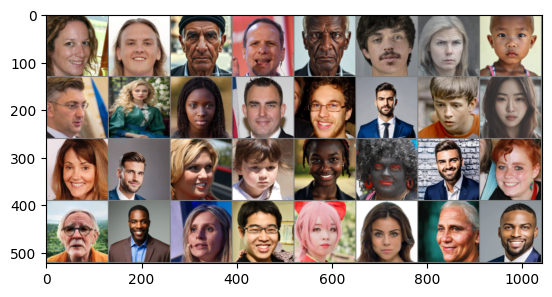

Train Labels: real_color real_color AI    real_color AI    AI    AI    AI   


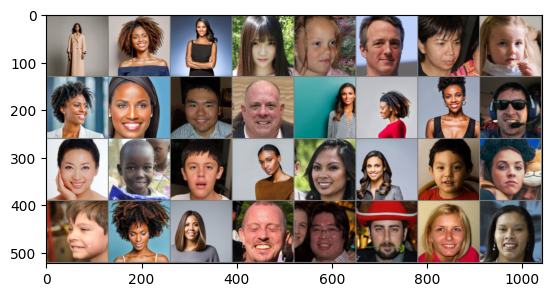

Validation Labels: AI    AI    AI    real_color real_color real_color real_color real_color


In [6]:
# Functions to display an image
batch_size = 8
def imshow(img):
    img = img / 2 + 0.5     # unnormalize the image
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Fetch some random training images
dataiter_train = iter(trainloader)
images_train, labels_train = next(dataiter_train)

# Display the training images
imshow(torchvision.utils.make_grid(images_train))

# Print the corresponding training labels
print('Train Labels: ' + ' '.join(f'{classes[labels_train[j]]:5s}' for j in range(batch_size)))

# Fetch some random validation images
dataiter_val = iter(valloader)
images_val, labels_val = next(dataiter_val)

# Display the validation images
imshow(torchvision.utils.make_grid(images_val))

# Print the corresponding validation labels
print('Validation Labels: ' + ' '.join(f'{classes[labels_val[j]]:5s}' for j in range(batch_size)))

## **Defining a Convolutional Neural Network (CNN) for Image Classification**
##### This code defines a convolutional neural network (CNN) class named Net, designed for binary image classification. It comprises two convolutional layers with ReLU activation and max-pooling, followed by three fully connected layers. The forward method models the forward pass, sequentially applying these layers to transform input images into class predictions. This setup effectively extracts features and classifies the data, and the network can be instantiated for CPU or moved to GPU for faster computation.

In [7]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # First convolutional layer
        self.pool = nn.MaxPool2d(2, 2) # Max pooling layer
        self.conv2 = nn.Conv2d(6, 16, 5) # Second convolutional layer
        self.fc1 = nn.Linear(16 * 29 * 29, 120)  # First fully connected layer
        self.fc2 = nn.Linear(120, 84) # Second fully connected layer
        self.fc3 = nn.Linear(84, 2)  # Output layer for 2 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # Apply first conv layer and pooling
        x = self.pool(F.relu(self.conv2(x))) # Apply second conv layer and pooling
        x = torch.flatten(x, 1) # Flatten all dimensions except batch
        x = F.relu(self.fc1(x)) # Forward pass through first fully connected layer
        x = F.relu(self.fc2(x)) # Forward pass through second fully connected layer
        x = self.fc3(x) # Output layer
        return x

# net = Net()             # Use this for CPU
net = Net().to(device)    # Move the model to GPU

## **Defining a Loss function and optimizer**
###### I chose Stochastic Gradient Descent (SGD) over Adam because it often provides better generalization for certain datasets and allows for clearer hyperparameter tuning. Its simplicity leads to more stable convergence, particularly with larger batch sizes, making it a suitable choice for my classification task.

In [8]:
# Define the loss function for training
criterion = nn.CrossEntropyLoss() # This is used for multi-class classification

# Set up the optimizer for updating the model's parameters
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) # Stochastic Gradient Descent with momentum

# Alternative optimizer: Adam optimizer for adaptive learning rate
# optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

## **Training the Neural Network**
##### An early stopping mechanism is implemented based on validation loss to mitigate overfitting. This technique terminates training when performance on the validation set starts to decline, preventing excessive fitting to the training data and enhancing overall model generalization.


In [9]:
# Measure the time taken for the cell execution:
%%time

train_losses = [] # Initialize a list to store training losses for each epoch
val_losses = []  # List to store validation losses
best_val_loss = float("inf") # Initialize best validation loss to infinity
patience = 8 # Number of epochs to wait before early stopping
epochs_no_improve = 0 # Counter for epochs without improvement in validation loss

# Loop through a specified number of epochs
for epoch in range(50):
    running_loss = 0.0  # Initialize cumulative loss for the current epoch

    # Iterate through the training data
    for i, data in enumerate(trainloader): # Iterate over the number of epochs
        inputs, labels = data  # Get the input images and their corresponding labels

        inputs = inputs.to(device)  # Move inputs to the device (GPU or CPU)
        labels = labels.to(device)  # Move labels to the device

        optimizer.zero_grad()  # Clear previous gradients

        outputs = net(inputs)  # Forward pass: compute the model's predictions

        loss = criterion(outputs, labels)  # Compute the training loss

        loss.backward()  # Backward pass: compute gradients
        optimizer.step()  # Update model parameters

        running_loss += loss.item()  # Accumulate the training loss

    epoch_loss = running_loss / len(trainloader)  # Average loss for the epoch
    train_losses.append(epoch_loss)  # Store the epoch loss
    print(f"Epoch {epoch+1}, Training loss: {epoch_loss:.4f}")  # Print the training loss for the current epoch

    # Validation phase
    net.eval()  # Set the model to evaluation mode
    val_running_loss = 0.0  # Initialize cumulative validation loss

    with torch.no_grad():  # Disable gradient calculation for validation
        for data in valloader:
            inputs, labels = data  # Get the validation images and labels
            inputs = inputs.to(device)  # Move inputs to the device
            labels = labels.to(device)  # Move labels to the device

            outputs = net(inputs)  # Forward pass: compute predictions
            loss = criterion(outputs, labels)  # Compute validation loss
            val_running_loss += loss.item()  # Accumulate validation loss

    val_epoch_loss = val_running_loss / len(valloader)  # Average validation loss for the epoch
    val_losses.append(val_epoch_loss)  # Store the validation loss
    print(f"Epoch {epoch+1}, Validation loss: {val_epoch_loss:.4f}")  # Print validation loss

    if val_epoch_loss < best_val_loss: # If the current validation loss is the best
        best_val_loss = val_epoch_loss # Update best validation loss
        epochs_no_improve = 0 # Reset the no-improve counter
        torch.save(net.state_dict(), "best_model.pth") # Save the best model
    else: # If the validation loss did not improve
        epochs_no_improve += 1 # Increment the no-improve counter
        if epochs_no_improve >= patience: # Check if patience limit is reached
            print("Early stopping") # Indicate early stopping condition met
            break  # Exit the training loop if no improvement

print("Finished Training")  # Indicate the training process is complete

Epoch 1, Training loss: 0.6524
Epoch 1, Validation loss: 0.5368
Epoch 2, Training loss: 0.3123
Epoch 2, Validation loss: 0.2227
Epoch 3, Training loss: 0.2303
Epoch 3, Validation loss: 0.1671
Epoch 4, Training loss: 0.2078
Epoch 4, Validation loss: 0.1695
Epoch 5, Training loss: 0.1846
Epoch 5, Validation loss: 0.1348
Epoch 6, Training loss: 0.1659
Epoch 6, Validation loss: 0.1114
Epoch 7, Training loss: 0.1471
Epoch 7, Validation loss: 0.1121
Epoch 8, Training loss: 0.1353
Epoch 8, Validation loss: 0.1165
Epoch 9, Training loss: 0.1181
Epoch 9, Validation loss: 0.1045
Epoch 10, Training loss: 0.1121
Epoch 10, Validation loss: 0.1004
Epoch 11, Training loss: 0.0985
Epoch 11, Validation loss: 0.0892
Epoch 12, Training loss: 0.0839
Epoch 12, Validation loss: 0.1183
Epoch 13, Training loss: 0.0725
Epoch 13, Validation loss: 0.0827
Epoch 14, Training loss: 0.0650
Epoch 14, Validation loss: 0.0939
Epoch 15, Training loss: 0.0536
Epoch 15, Validation loss: 0.1128
Epoch 16, Training loss: 0.0

## **Learning Curve**
##### Visualizing Training Results: The training loss graph demonstrates that the model has effectively learned from the training data, as indicated by the steady decline in training loss. The validation loss shows a similar downward trend initially but stabilizes afterward, suggesting good performance on unseen data. The implementation of early stopping has effectively prevented overfitting, allowing the model to maintain strong validation performance without excessive tuning to the training dataset. Overall, the close alignment between the training and validation loss lines reflects the model's good generalization capabilities.

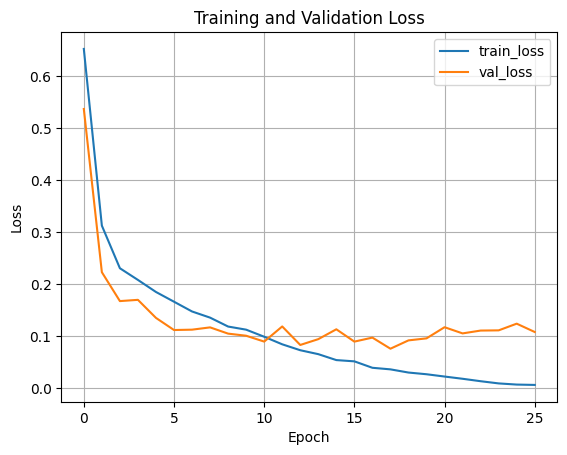

In [10]:
def plot_history(train_losses, val_losses):
    plt.figure()  # Create a new figure for the plot
    plt.plot(train_losses, label="train_loss")  # Plot the training losses
    plt.plot(val_losses, label="val_loss")      # Plot the validation losses
    plt.xlabel("Epoch")                         # Label for the x-axis
    plt.ylabel("Loss")                          # Label for the y-axis
    plt.title("Training and Validation Loss")   # Title of the plot
    plt.grid(True)                              # Add a grid for better readability
    plt.legend()                                # Show the legend on the plot
    plt.show()                                  # Display the plot

# Check if 'train_losses' and 'val_losses' exist and are not empty before plotting
if 'train_losses' in globals() and train_losses and 'val_losses' in globals() and val_losses:
    plot_history(train_losses, val_losses)  # Call the plotting function with training and validation losses
else:
    print("Error: 'train_losses' or 'val_losses' not found or is empty. Please run the training cell first.")  # Error message if the lists are unavailable

## **Validation Accuracy**

In [11]:
# Load the best saved model
best_model = Net().to(device)
best_model.load_state_dict(torch.load("best_model.pth", map_location=device))
best_model.eval()

correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in valloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = best_model(inputs)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

final_val_accuracy = correct / total
print(f"Final Validation Accuracy (best model): {final_val_accuracy:.4f}")

Final Validation Accuracy (best model): 0.9800


###### This high validation accuracy indicates that the model has effectively learned from the training data and is performing well on unseen data, suggesting strong generalization capabilities without signs of overfitting.

## **Saving the Trained Model**

#### The cell below requires your input to SAVE THE MODEL.
#### Input Requirements: Please enter your DESIRED DIRECTORY in the designated section below this code. The window for input will show up once you run this cell.

In [12]:
# ENTER YOUR DESIRED DIRECTORY TO SAVE THE MODEL
# Please enter your input in the designated section below this code. The output will show up once you run this cell.
save_directory = input("Enter the directory to save the model:")

# Local path on my Google Colab:
# save_directory = '/content/drive/MyDrive/Colab_Notebooks/Generated_photo_detector_cnn_final_version'

# Define the file name for the saved model
file_name = 'ai_real_net_v7.pth'

# Create the full path for saving the model
PATH = os.path.join(save_directory, file_name)

# Create the parent directory if it doesn't exist
os.makedirs(os.path.dirname(PATH), exist_ok=True)

# Save the model state dict to the specified path
torch.save(net.state_dict(), PATH)

# Print confirmation message with the model save location
print(f'Model saved successfully at {PATH}')

Enter the directory to save the model:/content/drive/MyDrive/Colab_Notebooks/Generated_photo_detector_cnn_final_version
Model saved successfully at /content/drive/MyDrive/Colab_Notebooks/Generated_photo_detector_cnn_final_version/ai_real_net_v7.pth


## **Loading the Saved Model and Summary of Architecture**
##### The summary outlines the model's architecture, consisting of two convolutional layers—one with 456 parameters and the other without—followed by a max pooling layer containing 2,416 parameters. Three fully connected layers conclude the architecture, with the final layer having 170 parameters for class predictions. The model features approximately 1,628,046 trainable parameters, and its estimated total size is about 7.79 MB, indicating the computational resources needed for training and inference.

In [13]:
# Initialize the neural network model
net = Net()

# Load the model's weights from the specified path
net.load_state_dict(torch.load(PATH, map_location=device))  # Specify map_location for compatibility

# Move the model to the appropriate device
net.to(device)

# Set the model to evaluation mode
net.eval()  # Important for layers like dropout and batch normalization if they are present

# Display a summary of the model architecture with the corrected input size
summary(net, (3, 128, 128))  # Display the model summary for input size of (3, 128, 128)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 124, 124]             456
         MaxPool2d-2            [-1, 6, 62, 62]               0
            Conv2d-3           [-1, 16, 58, 58]           2,416
         MaxPool2d-4           [-1, 16, 29, 29]               0
            Linear-5                  [-1, 120]       1,614,840
            Linear-6                   [-1, 84]          10,164
            Linear-7                    [-1, 2]             170
Total params: 1,628,046
Trainable params: 1,628,046
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 1.39
Params size (MB): 6.21
Estimated Total Size (MB): 7.79
----------------------------------------------------------------


## **Testing the Network on Test Data**


#### Preparing and Predicting Test Images


In [14]:
net.eval() # Set the model to evaluation mode

dataiter = iter(testloader)  # Create an iterator for the test data loader
images, true_labels = next(dataiter)  # Get a batch of images and their true labels

images = images.to(device)  # Move images to the appropriate device

# Perform a forward pass and get predictions without calculating gradients
with torch.no_grad():
    outputs = net(images)

_, predicted_labels = torch.max(outputs, 1) # Get the predicted class indices

print("Retrieved a batch of test images and generated predictions.")
print(f"Number of images in batch: {len(images)}")
print(f"True labels (first 10): {true_labels[:10].tolist()}")
print(f"Predicted labels (first 10): {predicted_labels[:10].tolist()}")

Retrieved a batch of test images and generated predictions.
Number of images in batch: 32
True labels (first 10): [0, 0, 0, 1, 1, 1, 1, 0, 1, 1]
Predicted labels (first 10): [0, 0, 0, 1, 1, 0, 1, 0, 1, 1]


#### Displaying Images with Actual and Predicted Labels


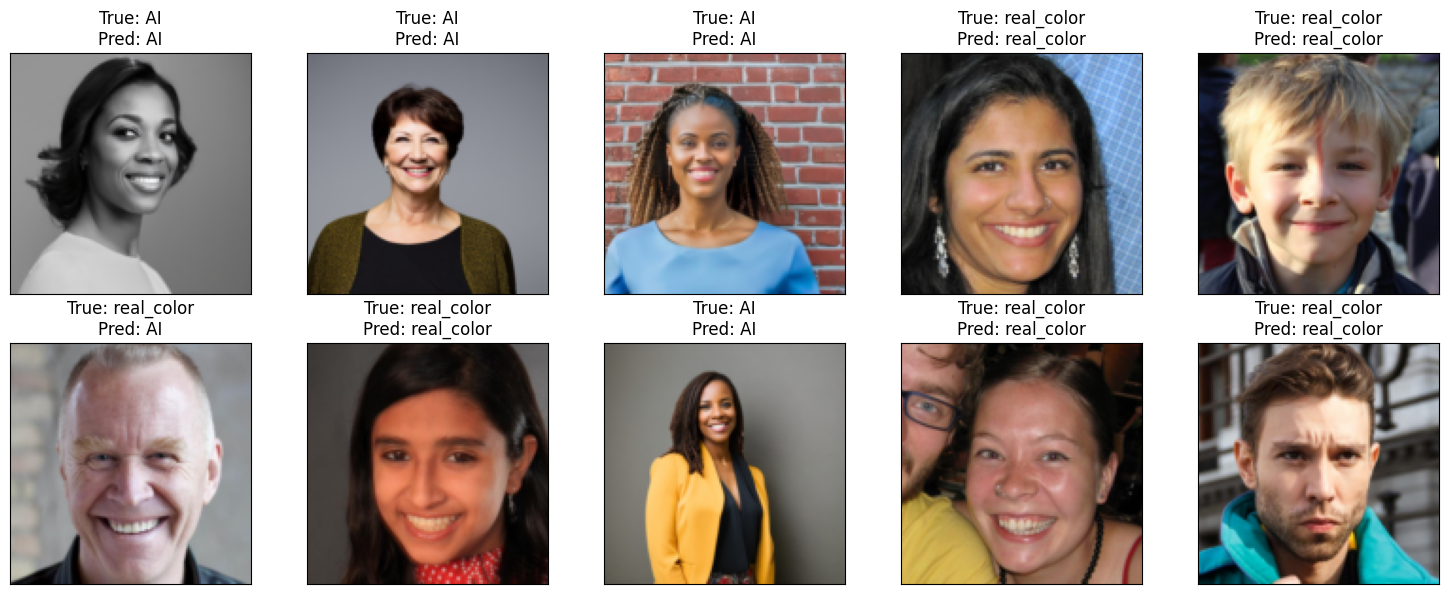

In [15]:
num_display = 10

fig = plt.figure(figsize=(15, 6))

for idx in range(num_display):
    ax = fig.add_subplot(2, 5, idx + 1, xticks=[], yticks=[])

    # Unnormalize the image and transpose dimensions
    img_display = images[idx].cpu().numpy()
    img_display = img_display / 2 + 0.5
    img_display = np.transpose(img_display, (1, 2, 0))

    # Display the image
    ax.imshow(img_display)

    # Set title with true and predicted labels
    ax.set_title(f"True: {classes[true_labels[idx]]}\nPred: {classes[predicted_labels[idx]]}")

plt.tight_layout()
plt.show()

## **Evaluating Network Performance on the Entire Dataset**
### **Overall Accuracy**

In [16]:
correct = 0  # Initialize a counter for correctly classified images
total = 0    # Initialize a counter for the total number of images

# Disable gradient calculation for evaluation
with torch.no_grad():
    for data in testloader:  # Iterate through batches of test data
        images, labels = data  # Get images and their corresponding labels

        # Move inputs to the appropriate device for processing
        images = images.to(device)
        labels = labels.to(device)

        # Calculate outputs by passing images through the network
        outputs = net(images)

        # Determine the predicted class by finding the index of the highest score
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)  # Update the total number of images processed
        correct += (predicted == labels).sum().item()  # Count correct predictions

# Calculate and print the accuracy of the network on the test dataset
accuracy = 100 * correct / total if total > 0 else 0  # Prevent division by zero
print(f'Accuracy of the network on the test images: {accuracy:.2f} %')  # Print accuracy formatted to two decimal places

Accuracy of the network on the test images: 97.60 %


### **Classification Report**

In [18]:
# Ensure the model is in evaluation mode and on the correct device
net.eval()
all_labels = []
all_predictions = []

# Disable gradient calculation for efficiency during evaluation
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        outputs = net(images)
        _, predicted = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Generate the classification report
report = classification_report(all_labels, all_predictions, target_names=classes)

# Print the report
print(report)

              precision    recall  f1-score   support

          AI       0.97      0.98      0.98      1001
  real_color       0.98      0.97      0.98      1001

    accuracy                           0.98      2002
   macro avg       0.98      0.98      0.98      2002
weighted avg       0.98      0.98      0.98      2002



### **Confusion Matrix**

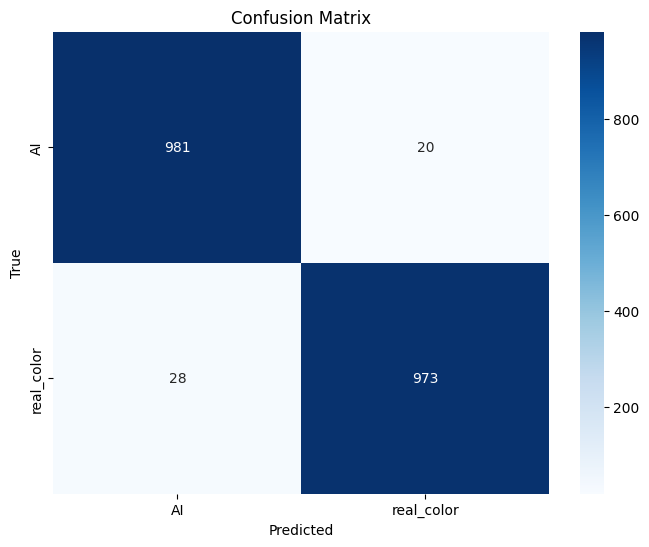

In [19]:
# Ensure the model is in evaluation mode and on the correct device
net.eval()
all_labels = []
all_predictions = []

# Disable gradient calculation for efficiency during evaluation
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        outputs = net(images)
        _, predicted = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Calculate the confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

#### Overall, the confusion matrix indicates that the model performs well, achieving high accuracy for both classes. The low false positive and false negative rates suggest that the model has good generalization capabilities and effectively distinguishes between AI-generated and real images.

#### In conclusion, the combination of a strong final validation accuracy, high test accuracy, and favorable loss trends suggests that the model likely does not suffer from overfitting and can generalize effectively to new, unseen data.